In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import osmnx as ox
import networkx as nx
import geopandas as gpd
import random
import pandas as pd
import pickle
import os
import pyproj
from shapely.geometry import Point, LineString
from datetime import datetime, timedelta
import ast
from geopy.distance import geodesic
from polyline import decode as decode_polyline
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Z-score normalization
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,make_scorer,f1_score, precision_score, recall_score, balanced_accuracy_score

from datetime import date

today_date = date.today()
formatted_date = today_date.strftime("%Y-%m-%d")
prior_day = today_date - timedelta(days=6)

scaler = MinMaxScaler()
# Initialize a LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


In [2]:
df_ml = pd.read_csv('C:\\Users\\Camelia\\Desktop\\app\\Disertatie\\ML\\MLDatasetUntil_'+(today_date-timedelta(days=11)).strftime("%Y-%m-%d")+'.csv')

congestion_mapping = {
    'Low Congestion': 0,
    'Moderate Congestion': 1,
    'High Congestion': 2
}
day_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}
weather_mapping={
'scattered clouds': 0,
'broken clouds': 1,
'overcast clouds': 2,
'light rain': 3,
'moderate rain' : 4,
'heavy intensity rain': 5,
'few clouds': 6,
'clear sky':7

}
# Map the congestion levels

df_ml['congestion_level'] = df_ml['congestion_level'].map(congestion_mapping)
df_ml['day_of_week'] = df_ml['day_of_week'].map(day_mapping)
df_ml['weather_data'] = df_ml['weather_data'].map(weather_mapping)
#df_ml['congestion_level'] = label_encoder.fit_transform(df_ml['congestion_level'].values)
X = df_ml.drop(['congestion_level','timestamp','origin_osmid','destination_osmid','Unnamed: 0'], axis=1)  # Features are all columns except 'congestion_level'
y = df_ml['congestion_level']  # Target variable is 'congestion_level' column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
rf_regressor = RandomForestClassifier(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

In [9]:
# Print confusion matrix and classification report with corresponding labels
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_labels, columns=class_labels))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_labels))


Confusion Matrix:
                     Low Congestion  Moderate Congestion  High Congestion
Low Congestion                14446                   10                0
Moderate Congestion              14                 9578               95
High Congestion                   1                   99             1345

Classification Report:
                     precision    recall  f1-score   support

     Low Congestion       1.00      1.00      1.00     14456
Moderate Congestion       0.99      0.99      0.99      9687
    High Congestion       0.93      0.93      0.93      1445

           accuracy                           0.99     25588
          macro avg       0.97      0.97      0.97     25588
       weighted avg       0.99      0.99      0.99     25588



In [7]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)

In [8]:
# Print confusion matrix and classification report with corresponding labels
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_labels, columns=class_labels))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_labels))


Confusion Matrix:
                     High Congestion  Low Congestion  Moderate Congestion
High Congestion                   32              16                   56
Low Congestion                    41            1076                  242
Moderate Congestion               60             249                  535

Classification Report:
                     precision    recall  f1-score   support

    High Congestion       0.24      0.31      0.27       104
     Low Congestion       0.80      0.79      0.80      1359
Moderate Congestion       0.64      0.63      0.64       844

           accuracy                           0.71      2307
          macro avg       0.56      0.58      0.57      2307
       weighted avg       0.72      0.71      0.72      2307



In [3]:
class_labels = ['Low Congestion', 'Moderate Congestion', 'High Congestion']
# Initialize XGBoost classifier
#xgb_classifier = xgb.XGBClassifier(objective= 'multi:softmax',num_class=3)
#
## Train the classifier
#xgb_classifier.fit(X_train, y_train)
#
## Predictions on the testing set
#y_pred = xgb_classifier.predict(X_test)
## Print confusion matrix and classification report with corresponding labels
#
#print("\nConfusion Matrix:")
#print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=class_labels, columns=class_labels))
#print("\nClassification Report:")
#print(classification_report(y_test, y_pred, target_names=class_labels))

In [ ]:

# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=3, use_label_encoder=False, eval_metric='mlogloss')

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [20,25,50,100, 150, 200],
    'learning_rate': [0.0001,0.001,0.1],
    'max_depth': [3, 5, 7,9,11,13,15],
    'subsample': [0.6, 0.7,0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_iter' : [50,100,150,200],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2],
    'colsample_bytree': [0.3, 0.7, 1.0]
    
}

# Define scoring metrics
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'accuracy': make_scorer(accuracy_score)
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_classifier, param_distributions=param_dist, n_iter=10, scoring=scoring, refit='f1_weighted', n_jobs=-1, cv=3, random_state=42)
random_search.fit(X_train, y_train)
# Get the results
results = random_search.cv_results_

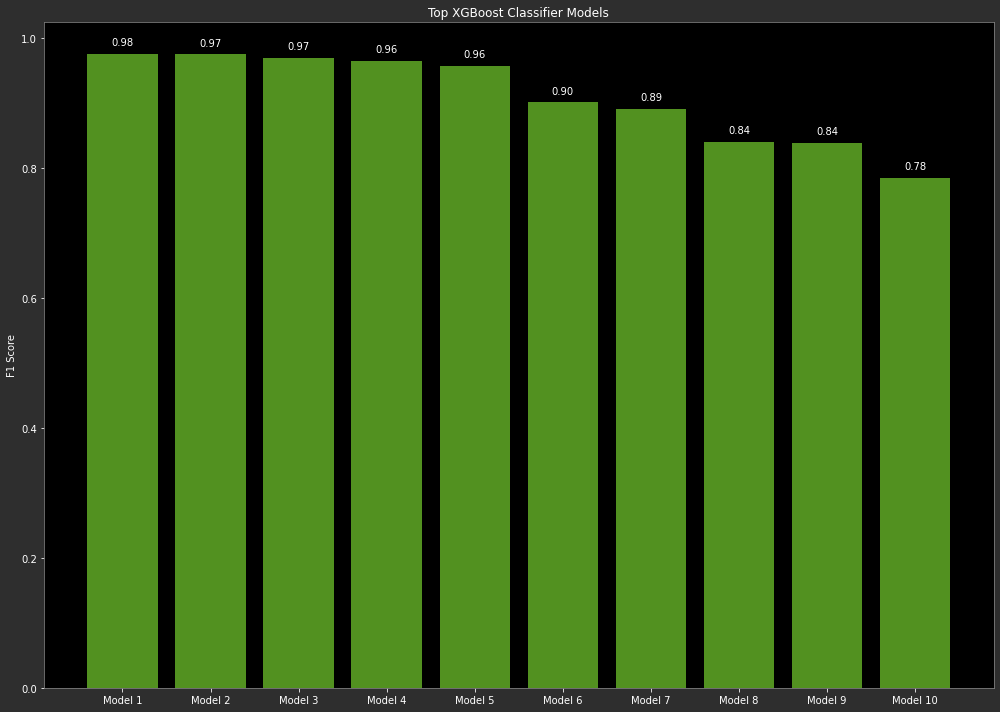

In [5]:
# Determine the number of valid models to extract
num_valid_models = min(len(results['rank_test_f1_weighted']), 10)

# Extract the indices of the top models based on F1 score
sorted_indices = sorted(range(len(results['rank_test_f1_weighted'])), key=lambda i: results['rank_test_f1_weighted'][i])[:num_valid_models]

# Extract the top models based on F1 score
top_params = [results['params'][i] for i in sorted_indices]
top_f1_scores = [results['mean_test_f1_weighted'][i] for i in sorted_indices]

# Create labels without parameters for the models
model_labels = [f"Model {i+1}" for i in range(num_valid_models)]

# Create a DataFrame to store the results
df = pd.DataFrame({
    'Model': model_labels,
    'F1 Score': top_f1_scores,
    'Params': top_params
})

# Plot the results
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 10))

# Plot F1 scores using vertical bars
bars = ax.bar(df['Model'], df['F1 Score'], color='#89f336', alpha=0.6, label='F1 Score')

# Add the F1 score values as text
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', ha='center', va='bottom')
fig.patch.set_facecolor('#2E2E2E')  # Set figure background color
ax.set_ylabel('F1 Score')
ax.set_title('Top XGBoost Classifier Models')
# Change the color of the spines to grey
ax.spines['top'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
plt.tight_layout()
plt.show()

In [11]:
# Export model
pickle.dump(xgb_classifier, open('model_XGB_1.pkl', 'wb'))
# Read the Model
#model_pre_trained = pickle.load(open('model_XGB.pkl','rb'))

In [18]:
features = X_test.iloc[0].values

# Create a DataFrame with the extracted features
test_df = pd.DataFrame([features], columns=X_test.columns)

# Make predictions
prediction = model_pre_trained.predict(test_df)
prediction.tolist()[0]

1